# Moving $x_s$ from stage to stage

In [53]:
import numpy as np
from dataLoad import dataset_from_name
from optimizer.linear3 import Optimal
import itertools
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook

Auxillary functions

In [54]:
def learn(X, y):
    N, n = X.shape
    num_feat = n - 1

    def get_counts(X):
        N, n = X.shape
        p = np.zeros(tuple([2] * n))
        for i in range(N):
            p[tuple(X[i, :])] += 1
        return p

    Xy = np.hstack((X, y))
    p = get_counts(X) / N
    py = get_counts(X[Xy[:, -1] == 1]) / N / (p + 10e-9)
    return p, py

def get_fairness(optimizer, alpha3, fairness_def):
    volfs = []
    gfs = []
    lfs = []
    for alpha1 in np.linspace(alpha3, 1, 5):
        for alpha2 in np.linspace(alpha3, alpha1, 5):
            gf, lf, volf = optimizer.minimize_violation([alpha1, alpha2, alpha3],  fairness_def=fairness_def, num_stage=3)
            gfs.append(gf)
            lfs.append(lf)
            volfs.append(volf)
    return np.array(gfs) / np.array(lfs), volfs

## Simulation procedure

Choose dataset_name:
* adult
* compas
* german

and fairness_def $\in$ {dp, eo}

In [69]:
from optimizer.greedy2 import Greedy
from optimizer.linear3 import Optimal
import pickle


dataset_name = "german"
fairness_def = "eo"

optimizer = Optimal()
alpha3 = 0.3

data = dataset_from_name(dataset_name).astype(int)
features = list(data)[:-1]
label = list(data)[-1]

try:
    polfs = pickle.load(open( "./data/polf-3-fair-{}-{}.pickle".format(dataset_name, fairness_def), "rb" ) )
    volfs = pickle.load(open( "./data/volf-3-fair-{}-{}.pickle".format(dataset_name, fairness_def), "rb" ) )
    keys = pickle.load(open( "./data/key-3-fair-{}-{}.pickle".format(dataset_name, fairness_def), "rb" ) )
except:
    polfs = {}
    volfs = {}
    keys = []
for Xs in features:   
    if Xs not in polfs:
        polfs[Xs] = []
        volfs[Xs] = []
    perm = itertools.permutations(features, 3)
    print (Xs)
    for feature_comb in tqdm_notebook(perm):
        if Xs not in feature_comb:
            key = tuple([Xs] + list(np.sort(feature_comb)))
            if key not in keys:
                p, py = learn(data[[Xs] + list(np.sort(feature_comb))].values, data[[label]].values)
                ps = {1: np.zeros((2,2,2,2,2,2,2)), 2: np.zeros((2,2,2,2,2,2,2)), 3: np.zeros((2,2,2,2,2,2,2)), 4: np.zeros((2,2,2,2))}
                pys = {1: np.zeros((2,2,2,2,2,2,2)), 2: np.zeros((2,2,2,2,2,2,2)), 3: np.zeros((2,2,2,2,2,2,2)), 4: np.zeros((2,2,2,2))}
                for xs, x1, x2, x3, x4 in itertools.product([0, 1], repeat=5): 
                    ps[1][xs, xs, x1, x2, x2, x3, x3] = p[xs,x1,x2,x3]
                    pys[1][xs, xs, x1, x2, x2, x3, x3] = py[xs,x1,x2,x3]

                    ps[2][xs, x1, x1, xs, x2, x3, x3] = p[xs,x1,x2,x3]
                    pys[2][xs, x1, x1, xs, x2, x3, x3] = py[xs,x1,x2,x3]

                    ps[3][xs, x1, x1, x2, x2, x3,xs] = p[xs,x1,x2,x3]
                    pys[3][xs, x1, x1, x2, x2, x3,xs] = py[xs,x1,x2,x3]
                    
                    ps[4][xs, x1, x2, x3] = p[xs,x1,x2,x3]
                    pys[4][xs, x1, x2, x3] = py[xs,x1,x2,x3]
                polf_temp, volf_temp = [], []
                for stage in [1, 2, 3, 4]:
                    optimizer.p = ps[stage]
                    optimizer.py = pys[stage]
                    if stage == 4:
                        optimizer.num_feat = 3
                    else:
                        optimizer.num_feat = 6
                    polf, volf = get_fairness(optimizer, alpha3, fairness_def)
                    polf_temp.append(polf)
                    volf_temp.append(volf)

                polfs[Xs].append(polf_temp)
                volfs[Xs].append(volf_temp)

                keys.append(key)
            pickle.dump(keys, open("./data/key-3-fair-{}-{}.pickle".format(dataset_name, fairness_def), "wb"))
            pickle.dump(polfs, open("./data/polf-3-fair-{}-{}.pickle".format(dataset_name, fairness_def), "wb"))
            pickle.dump(volfs, open("./data/volf-3-fair-{}-{}.pickle".format(dataset_name, fairness_def), "wb"))

job


/usr/local/lib/python3.7/site-packages/pulp/pulp.py:1349: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")



housing



sex



savings



credit_history



age


## $PoLF_1$ vs $PoLF_2$ for Adult dataset

250 0.956
250 0.956
250 0.944


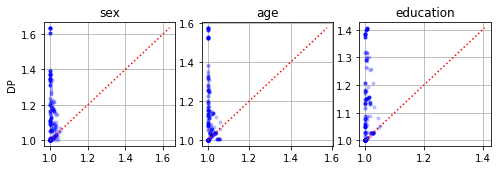

In [57]:
plt.figure(figsize=(8, 5))
s=1
dataset_name = "adult"
for fairness_def in ["dp"]:
    data = pickle.load(open("./data/polf-3-fair-{}-{}.pickle".format(dataset_name, fairness_def), "rb"))
#     features = list(dataset_from_name(dataset_name))
    for Xs in ["sex", "age", "education"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        polf = [[], [], [], []]
        for i in range(len(data[Xs])):
            for j in range(4):
                polf[j] += list(data[Xs][i][j])
        print (len(polf[0]), np.mean(np.array(polf[0]) < np.array(polf[1])))
        plt.plot(polf[0], polf[1], ".", color="blue", alpha=0.2)
#         plt.plot(polf[1], polf[2], ".", color="red", alpha=0.2)
        plt.plot([1, np.max(polf[1])], [1, np.max(polf[1])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-adult.pdf", bbox_inches="tight")

## $PoLF_2$ vs $PoLF_3$ for Adult dataset

250 0.888
250 0.996
250 1.0


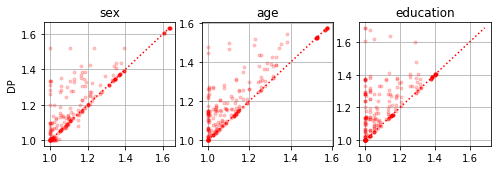

In [58]:
plt.figure(figsize=(8, 5))
s=1
dataset_name = "adult"
for fairness_def in ["dp"]:
    data = pickle.load(open("./data/polf-3-fair-{}-{}.pickle".format(dataset_name, fairness_def), "rb"))
    features = list(dataset_from_name(dataset_name))
    for Xs in ["sex", "age", "education"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        polf = [[], [], [], []]
        for i in range(len(data[Xs])):
            for j in range(4):
                polf[j] += list(data[Xs][i][j])
        print (len(polf[1]), np.mean(np.array(polf[1]) < np.array(polf[2])))
        plt.plot(polf[1], polf[2], ".", color="red", alpha=0.2)
        plt.plot([1, np.max(polf[2])], [1, np.max(polf[2])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-adult.pdf", bbox_inches="tight")

250 0.5
250 0.668
250 0.684


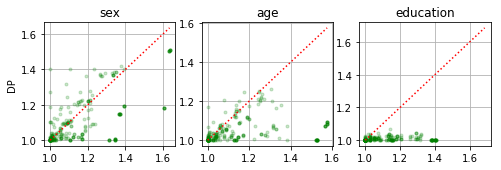

In [59]:
plt.figure(figsize=(8, 5))
s=1
dataset_name = "adult"
for fairness_def in ["dp",]:
    data = pickle.load(open("./data/polf-3-fair-{}-{}.pickle".format(dataset_name, fairness_def), "rb"))
    features = list(dataset_from_name(dataset_name))
    for Xs in ["sex", "age", "education"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        polf = [[], [], [], []]
        for i in range(len(data[Xs])):
            for j in range(4):
                polf[j] += list(data[Xs][i][j])
        print (len(polf[1]), np.mean(np.array(polf[1]) > np.array(polf[3])))
        plt.plot(polf[1], polf[3], ".", color="green", alpha=0.2)
        plt.plot([1, np.max(polf[2])], [1, np.max(polf[2])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-adult.pdf", bbox_inches="tight")

## $VoLF_1$ vs $VoLF_2$ for Adult dataset

250 0.308
250 0.248
250 0.232


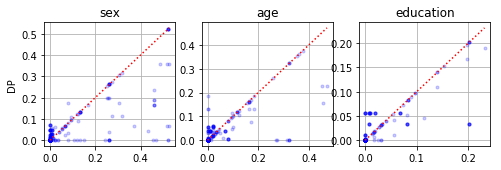

In [60]:
plt.figure(figsize=(8, 5))
s=1
dataset_name = "adult"
for fairness_def in ["dp", ]:
    data = pickle.load(open("./data/volf-3-fair-{}-{}.pickle".format(dataset_name, fairness_def), "rb"))
    features = list(dataset_from_name(dataset_name))
  
    for Xs in ["sex", "age", "education"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        volf = [[], [], [], []]
        for i in range(len(data[Xs])):
            for j in range(4):
                volf[j] += list(data[Xs][i][j])
        plt.plot(volf[0], volf[1], ".", color="blue", alpha=0.2)
        print (len(volf[0]), np.mean(np.array(volf[0]) > np.array(volf[1])))
        plt.plot([0, np.max(volf[0])], [0, np.max(volf[0])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-adult.pdf", bbox_inches="tight")

250 0.204
250 0.124
250 0.072


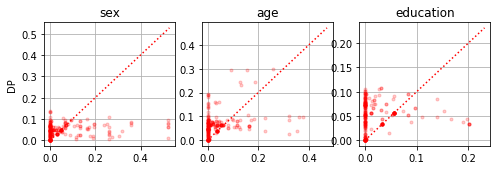

In [61]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp", ]:
    data = pickle.load(open("./data/volf-3-fair-adult-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "age", "education"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        volf = [[], [], [], []]
        for i in range(len(data[Xs])):
            for j in range(3):
                volf[j] += list(data[Xs][i][j])
        print (len(volf[0]), np.mean(np.array(volf[1]) > np.array(volf[2])))
        plt.plot(volf[1], volf[2], ".", color="red", alpha=0.2)
        plt.plot([0, np.max(volf[0])], [0, np.max(volf[0])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-adult.pdf", bbox_inches="tight")

250 0.204
250 0.124
250 0.072
250 0.192
250 0.112
250 0.104


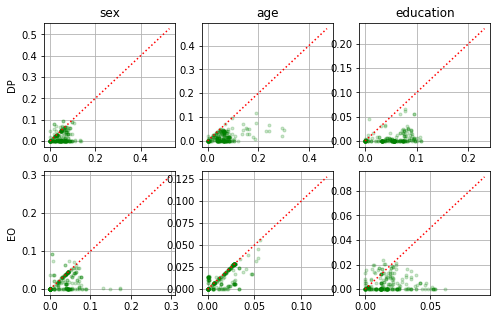

In [37]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp", "eo"]:
    data = pickle.load(open("./data/volf-3-fair-adult-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "age", "education"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        volf = [[], [], [], []]
        for i in range(len(data[Xs])):
            for j in range(4):
                volf[j] += list(data[Xs][i][j])
        print (len(volf[0]), np.mean(np.array(volf[1]) > np.array(volf[2])))
        plt.plot(volf[2], volf[3], ".", color="green", alpha=0.2)
        plt.plot([0, np.max(volf[0])], [0, np.max(volf[0])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-adult.pdf", bbox_inches="tight")

## $PoLF_1$ vs $PoLF_2$ for COMPAS dataset

250 0.94
250 0.948
250 0.948
250 0.892
250 0.92
250 0.968


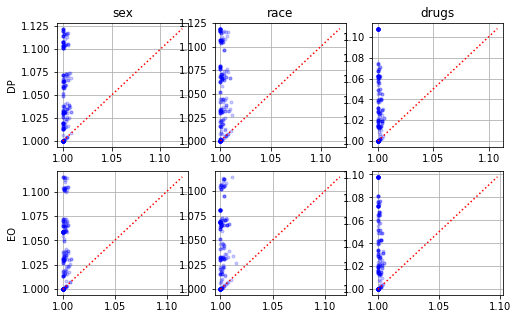

In [69]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp", "eo"]:
    data = pickle.load(open("./data/polf-3-fair-compas-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "race", "drugs"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        polf = [[], [], []]
        for i in range(len(data[Xs])):
            for j in range(3):
                polf[j] += list(data[Xs][i][j])
        print (len(polf[1]), np.mean(np.array(polf[0]) < np.array(polf[1])))
        plt.plot(polf[0], polf[1], ".", color="blue", alpha=0.2)
        plt.plot([1, np.max(polf[1])], [1, np.max(polf[1])], color="red", linestyle=":")
        plt.grid()
        s += 1
plt.savefig("../ijcai19/fig/polf1-polf2-compas.pdf", bbox_inches="tight")

## $PoLF_2$ vs $PoLF_3$ for COMPAS dataset

250 0.876
250 0.936
250 0.712
250 0.812
250 0.88
250 0.864


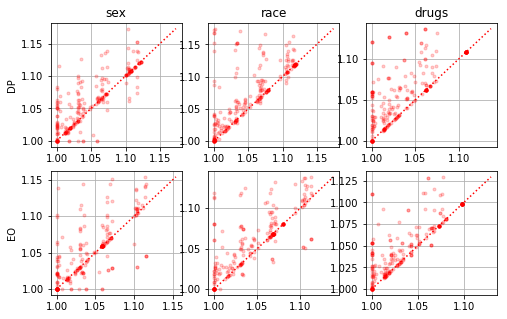

In [33]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp", "eo"]:
    data = pickle.load(open("./data/polf-3-fair-compas-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "race", "drugs"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        polf = [[], [], []]
        for i in range(len(data[Xs])):
            for j in range(3):
                polf[j] += list(data[Xs][i][j])
        print (len(polf[1]), np.mean(np.array(polf[1]) < np.array(polf[2])))
        plt.plot(polf[1], polf[2], ".", color="red", alpha=0.2)
        plt.plot([1, np.max(polf[2])], [1, np.max(polf[2])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-compas.pdf", bbox_inches="tight")

250 0.876
250 0.936
250 0.712
250 0.812
250 0.88
250 0.864


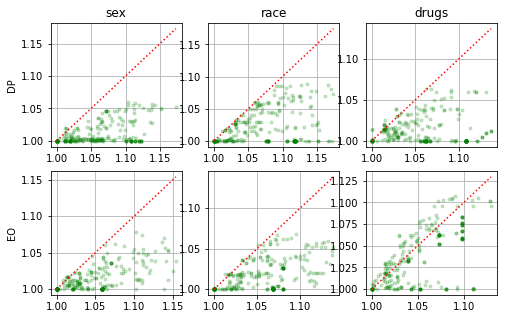

In [32]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp", "eo"]:
    data = pickle.load(open("./data/polf-3-fair-compas-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "race", "drugs"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        polf = [[], [], [], []]
        for i in range(len(data[Xs])):
            for j in range(4):
                polf[j] += list(data[Xs][i][j])
        print (len(polf[1]), np.mean(np.array(polf[1]) < np.array(polf[2])))
        plt.plot(polf[2], polf[3], ".", color="green", alpha=0.2)
        plt.plot([1, np.max(polf[2])], [1, np.max(polf[2])], color="red", linestyle=":")
        plt.grid()
        s += 1
plt.savefig("../ijcai19/fig/polf1-polf2-compas.pdf", bbox_inches="tight")

## VolF1 vs Volf2 for COMPAS

250 0.392
250 0.348
250 0.312
250 0.38
250 0.34
250 0.32


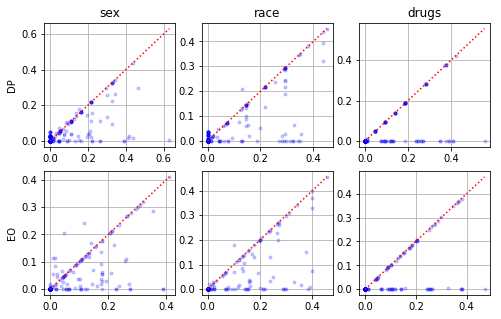

In [85]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp", "eo"]:
    data = pickle.load(open("./data/volf-3-fair-compas-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "race", "drugs"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        volf = [[], [], [], []]
        for i in range(len(data[Xs])):
            for j in range(3):
                volf[j] += list(data[Xs][i][j])
        print (len(volf[0]), np.mean(np.array(volf[0]) > np.array(volf[1])))
        plt.plot(volf[0], volf[1], ".", color="blue", alpha=0.2)
        plt.plot([0, np.max(volf[0])], [0, np.max(volf[0])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-adult.pdf", bbox_inches="tight")

250 0.268
250 0.192
250 0.144
250 0.24
250 0.176
250 0.176


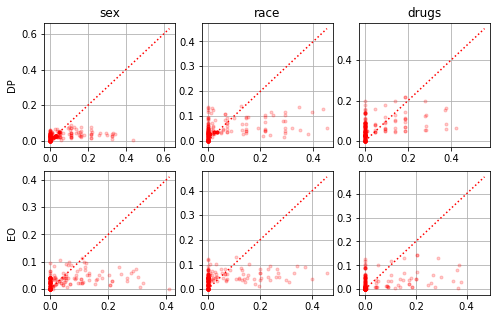

In [86]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp", "eo"]:
    data = pickle.load(open("./data/volf-3-fair-compas-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "race", "drugs"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        volf = [[], [], [], []]
        for i in range(len(data[Xs])):
            for j in range(3):
                volf[j] += list(data[Xs][i][j])
        print (len(volf[0]), np.mean(np.array(volf[1]) > np.array(volf[2])))
        plt.plot(volf[1], volf[2], ".", color="red", alpha=0.2)
        plt.plot([0, np.max(volf[0])], [0, np.max(volf[0])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-adult.pdf", bbox_inches="tight")

250 0.268
250 0.192
250 0.144
250 0.24
250 0.176
250 0.176


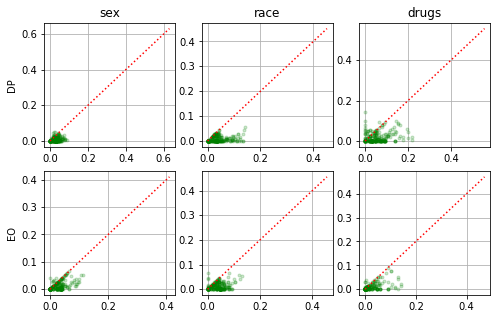

In [24]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp", "eo"]:
    data = pickle.load(open("./data/volf-3-fair-compas-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "race", "drugs"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        volf = [[], [], [], []]
        for i in range(len(data[Xs])):
            for j in range(4):
                volf[j] += list(data[Xs][i][j])
        print (len(volf[0]), np.mean(np.array(volf[1]) > np.array(volf[2])))
        plt.plot(volf[2], volf[3], ".", color="green", alpha=0.2)
        plt.plot([0, np.max(volf[0])], [0, np.max(volf[0])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-adult.pdf", bbox_inches="tight")

## $PoLF_1$ vs $PoLF_2$ for German dataset

250 0.9
250 0.928
250 0.852
250 0.812
250 0.908
250 0.872


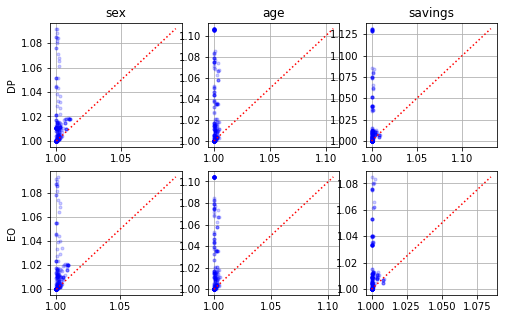

In [76]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp", "eo"]:
    data = pickle.load(open("./data/polf-3-fair-german-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "age", "savings"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        polf = [[], [], []]
        for i in range(len(data[Xs])):
            for j in range(3):
                polf[j] += list(data[Xs][i][j])
        print (len(polf[1]), np.mean(np.array(polf[0]) < np.array(polf[1])))
        plt.plot(polf[0], polf[1], ".", color="blue", alpha=0.2)
        plt.plot([1, np.max(polf[1])], [1, np.max(polf[1])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-german.pdf", bbox_inches="tight")

## $PoLF_2$ vs $PoLF_3$ for German dataset

250 0.852
250 0.912
250 0.912
250 0.868
250 0.912
250 0.772


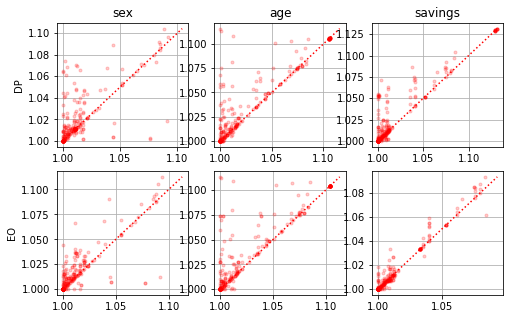

In [77]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp", "eo"]:
    data = pickle.load(open("./data/polf-3-fair-german-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "age", "savings"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        polf = [[], [], []]
        for i in range(len(data[Xs])):
            for j in range(3):
                polf[j] += list(data[Xs][i][j])
        print (len(polf[1]), np.mean(np.array(polf[1]) < np.array(polf[2])))
        plt.plot(polf[1], polf[2], ".", color="red", alpha=0.2)
        plt.plot([1, np.max(polf[2])], [1, np.max(polf[2])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-german.pdf", bbox_inches="tight")

##  $VoLF_1$ vs $VoLF_2$ for German dataset

250 0.32
250 0.244
250 0.212
250 0.34
250 0.248
250 0.2


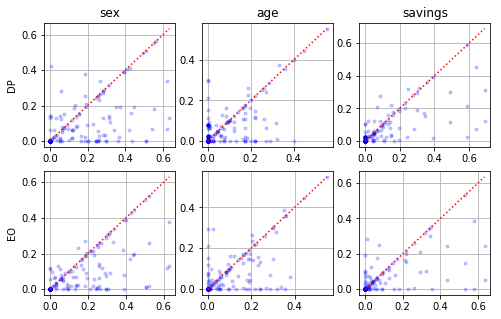

In [87]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp", "eo"]:
    data = pickle.load(open("./data/volf-3-fair-german-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "age", "savings"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        volf = [[], [], [], []]
        for i in range(len(data[Xs])):
            for j in range(3):
                volf[j] += list(data[Xs][i][j])
        print (len(volf[0]), np.mean(np.array(volf[0]) > np.array(volf[1])))
        plt.plot(volf[0], volf[1], ".", color="blue", alpha=0.2)
        plt.plot([0, np.max(volf[0])], [0, np.max(volf[0])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-adult.pdf", bbox_inches="tight")

##  $VoLF_2$ vs $VoLF_3$ for German dataset

250 0.232
250 0.204
250 0.244
250 0.256
250 0.232
250 0.24


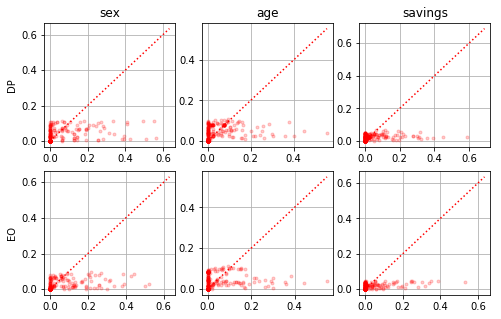

In [88]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp", "eo"]:
    data = pickle.load(open("./data/volf-3-fair-german-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "age", "savings"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        volf = [[], [], [], []]
        for i in range(len(data[Xs])):
            for j in range(3):
                volf[j] += list(data[Xs][i][j])
        print (len(volf[0]), np.mean(np.array(volf[1]) > np.array(volf[2])))
        plt.plot(volf[1], volf[2], ".", color="red", alpha=0.2)
        plt.plot([0, np.max(volf[0])], [0, np.max(volf[0])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-adult.pdf", bbox_inches="tight")

250 0.684
250 0.712
250 0.712
250 0.444
250 0.676
250 0.592


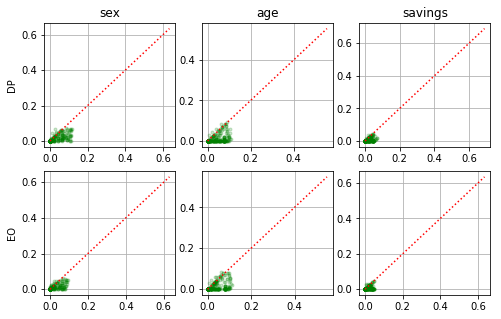

In [22]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp", "eo"]:
    data = pickle.load(open("./data/volf-3-fair-german-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "age", "savings"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        volf = [[], [], [], []]
        for i in range(len(data[Xs])):
            for j in range(4):
                volf[j] += list(data[Xs][i][j])
        print (len(volf[0]), np.mean(np.array(volf[2]) > np.array(volf[3])))
        plt.plot(volf[2], volf[3], ".", color="green", alpha=0.2)
        plt.plot([0, np.max(volf[0])], [0, np.max(volf[0])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-adult.pdf", bbox_inches="tight")